<a href="https://colab.research.google.com/github/sounak04/SAR_ADC_MATLAB/blob/master/another_terminal_copy_of_main_actor_critic_with_self_relection_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# Step 0 — GPU check & clean start
import torch, gc, os, shutil

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    print("VRAM (GB):", round(torch.cuda.get_device_properties(0).total_memory/1e9, 2))

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# scratch for offload
shutil.rmtree("/content/offload", ignore_errors=True)
os.makedirs("/content/offload", exist_ok=True)


CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
VRAM (GB): 85.17


In [35]:
# Step 1 — Install libs
!pip -q install --upgrade "transformers>=4.44.0" "accelerate>=0.33.0" "huggingface_hub>=0.24.0" bitsandbytes
!pip -q install sentencepiece einops requests pandas matplotlib


In [36]:
# Step 1.5 — Point to your tunnel & API key (must match your WSL exports)
import os

# <<< REPLACE these two with your values if they change >>>
NG_URL = "https://proportion-wondering-comply-combined.trycloudflare.com"  # base URL (NO trailing /run)
SPECTRE_API_KEY = "my-strong-secret-key"  # must match WSL's export

# sanitize & export
os.environ["NG_URL"] = NG_URL.strip()
os.environ["SPECTRE_API_KEY"] = SPECTRE_API_KEY

print("NG_URL:", os.environ["NG_URL"])
print("SPECTRE_API_KEY set? ", bool(os.environ.get("SPECTRE_API_KEY")))


NG_URL: https://proportion-wondering-comply-combined.trycloudflare.com
SPECTRE_API_KEY set?  True


In [37]:
# Step 2 — SKY130 PDK ranges
from dataclasses import dataclass

@dataclass
class Sky130Preset:
    name: str = "sky130_01v8_core"
    VDD: float = 1.8
    Lmin_um: float = 0.18
    Lmax_um: float = 2.0
    Wn_um_range: tuple = (0.42, 120.0)
    Wp_um_range: tuple = (0.42, 180.0)
    W2n_um_range: tuple = (0.42, 120.0)
    W2p_um_range: tuple = (0.42, 180.0)
    Ib_mA_range: tuple = (0.01, 5.00)      # mA
    Ccomp_pF_range: tuple = (0.2, 5.0)     # pF
    Rz_ohm_range: tuple = (200.0, 5000.0)  # ohm

def make_sky130_pdk():
    p = Sky130Preset()
    return {
        "preset": p.name,
        "VDD": p.VDD,
        "vars": {
            "Wn_um":     p.Wn_um_range,
            "Wp_um":     p.Wp_um_range,
            "W2n_um":    p.W2n_um_range,
            "W2p_um":    p.W2p_um_range,
            "L_um":      (p.Lmin_um, p.Lmax_um),
            "Ib_mA":     p.Ib_mA_range,
            "Ccomp_pF":  p.Ccomp_pF_range,
            "Rz_ohm":    p.Rz_ohm_range,
        },
    }

PDK = make_sky130_pdk()

def pdk_midpoint(pdk):
    return {k: (lo+hi)/2.0 for k,(lo,hi) in pdk["vars"].items()}

PDK


{'preset': 'sky130_01v8_core',
 'VDD': 1.8,
 'vars': {'Wn_um': (0.42, 120.0),
  'Wp_um': (0.42, 180.0),
  'W2n_um': (0.42, 120.0),
  'W2p_um': (0.42, 180.0),
  'L_um': (0.18, 2.0),
  'Ib_mA': (0.01, 5.0),
  'Ccomp_pF': (0.2, 5.0),
  'Rz_ohm': (200.0, 5000.0)}}

In [38]:
# Step 3 — Loader
import gc, torch, os
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
try:
    from transformers import BitsAndBytesConfig
except Exception:
    BitsAndBytesConfig = None

BASE_REPO       = "openai/gpt-oss-20b"
ACTOR_REVISION  = "main"
CRITIC_REVISION = "main"

ROLE_CACHE = {}

def _common_kwargs(gpu_gib=11, cpu_gib=48, offload_dir="/content/offload"):
    os.makedirs(offload_dir, exist_ok=True)
    kw = dict(
        device_map="auto",
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        offload_folder=offload_dir,
        max_memory={"cpu": f"{cpu_gib}GiB"},
    )
    if torch.cuda.is_available():
        kw["max_memory"][0] = f"{gpu_gib}GiB"
    return kw

def load_llm_smart(repo_id=BASE_REPO, revision="main", gpu_gib=11, cpu_gib=48, offload_dir="/content/offload"):
    tok = AutoTokenizer.from_pretrained(repo_id, revision=revision, use_fast=True, trust_remote_code=True)
    if tok.pad_token_id is None:
        tok.pad_token_id = tok.eos_token_id

    cfg = AutoConfig.from_pretrained(repo_id, revision=revision, trust_remote_code=True)
    qcfg = getattr(cfg, "quantization_config", None)
    kw = _common_kwargs(gpu_gib=gpu_gib, cpu_gib=cpu_gib, offload_dir=offload_dir)

    if qcfg is not None:
        model = AutoModelForCausalLM.from_pretrained(repo_id, revision=revision, **kw)
    else:
        if BitsAndBytesConfig is not None:
            bnb_q = BitsAndBytesConfig(
                load_in_4bit=True,
                bnb_4bit_quant_type="nf4",
                bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
                bnb_4bit_use_double_quant=True,
            )
            model = AutoModelForCausalLM.from_pretrained(repo_id, revision=revision, quantization_config=bnb_q, **kw)
        else:
            model = AutoModelForCausalLM.from_pretrained(
                repo_id, revision=revision,
                torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
                **kw
            )
    model.eval()
    torch.set_grad_enabled(False)
    return model, tok

def get_shared_llm():
    key = ("shared_llm", BASE_REPO, ACTOR_REVISION)
    if key not in ROLE_CACHE:
        ROLE_CACHE[key] = load_llm_smart(BASE_REPO, ACTOR_REVISION)
    return ROLE_CACHE[key]

def get_fresh_llm(tag="fresh_single"):
    key = (tag, BASE_REPO, "main")
    if key not in ROLE_CACHE:
        ROLE_CACHE[key] = load_llm_smart(BASE_REPO, "main")
    return ROLE_CACHE[key]

def free_all_roles():
    ROLE_CACHE.clear()
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


In [39]:
# Step 4 — Chat helper + JSON extractor
import torch, json

def chat(model, tok, messages,
         max_new_tokens=64, temperature=0.6, top_p=0.9,
         greedy=False, max_time=6.0, repetition_penalty=None):
    input_ids = tok.apply_chat_template(messages, add_generation_prompt=True,
                                        return_tensors="pt").to(model.device)
    attention_mask = torch.ones_like(input_ids)  # prevents pad=eos warning

    gen_kwargs = dict(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_new_tokens=max_new_tokens,
        do_sample=not greedy,
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tok.eos_token_id,
        max_time=max_time,
    )
    if repetition_penalty is not None:
        gen_kwargs["repetition_penalty"] = repetition_penalty

    with torch.no_grad():
        out = model.generate(**gen_kwargs)
    new_tokens = out[0, input_ids.shape[-1]:]
    return tok.decode(new_tokens, skip_special_tokens=True).strip()

def find_json_block(text):
    s = text.find("{")
    if s < 0: raise ValueError("No JSON found")
    depth = 0
    for i, ch in enumerate(text[s:], s):
        if ch == "{": depth += 1
        elif ch == "}":
            depth -= 1
            if depth == 0:
                return json.loads(text[s:i+1])
    raise ValueError("Unbalanced braces")


In [40]:
# Step 5 — Real simulator: ngspicerunner via Cloudflare tunnel
import requests, os, math

NG_BASE = os.environ["NG_URL"].strip().rstrip("/")
SPECTRE_API_KEY = os.environ["SPECTRE_API_KEY"]

# final endpoint
SPECTRE_URL = NG_BASE if NG_BASE.endswith("/run") else (NG_BASE + "/run")
print("Simulator endpoint:", SPECTRE_URL)

def _finite(x, fallback):
    try:
        xv = float(x)
        if math.isfinite(xv):
            return xv
    except Exception:
        pass
    return float(fallback)

def simulate_metrics_ng(x: dict) -> dict:
    payload = {
        "Wn_um":   float(x["Wn_um"]),
        "Wp_um":   float(x["Wp_um"]),
        "W2n_um":  float(x["W2n_um"]),
        "W2p_um":  float(x["W2p_um"]),
        "L_um":    float(x["L_um"]),
        "Ib_mA":   float(x["Ib_mA"]),
        "Ccomp_pF":float(x["Ccomp_pF"]),
        "Rz_ohm":  float(x["Rz_ohm"]),
        "VDD":     float(PDK["VDD"]),
    }
    try:
        r = requests.post(SPECTRE_URL, json=payload,
                          headers={"x-api-key": SPECTRE_API_KEY}, timeout=120)
        r.raise_for_status()
        obj = r.json()
    except Exception as e:
        # Hard failure: return conservative-but-finite metrics
        return {
            "gain_dB": 0.0, "ugbw_MHz": 0.0, "phase_margin_deg": 0.0,
            "power_mW": 1e3, "aux": {"err":"http", "msg": str(e)}
        }

    a0_db = _finite(obj.get("a0_db", 0.0), 0.0)
    ughz  = obj.get("ugbw_hz", None)
    ugbw  = _finite(ughz/1e6 if ughz is not None else 0.0, 0.0)
    pm    = _finite(obj.get("phase_margin_deg", 0.0), 0.0)
    pwr   = _finite(obj.get("power_mw", 1e3), 1e3)

    # If DC is railed, penalize
    if (obj.get("bias_ok") is False) or (obj.get("voutp_dc") in (0.0, 1.8)) or (obj.get("voutm_dc") in (0.0, 1.8)):
        a0_db = float(a0_db)
        ugbw  = 0.0
        pm    = 0.0
        pwr   = max(pwr, 1e3)

    return {
        "gain_dB": float(a0_db),
        "ugbw_MHz": float(ugbw),
        "phase_margin_deg": float(pm),
        "power_mW": float(pwr),
        "aux": {
            "bias_ok": obj.get("bias_ok"),
            "vbp_dc": obj.get("vbp_dc"),
            "voutp_dc": obj.get("voutp_dc"),
            "voutm_dc": obj.get("voutm_dc"),
            "mode": obj.get("mode"),
        }
    }

# Optional probe
try:
    probe = pdk_midpoint(PDK)
    m = simulate_metrics_ng({
        **probe,
        "W2n_um": probe["W2n_um"],
        "W2p_um": probe["W2p_um"],
        "Ccomp_pF": probe["Ccomp_pF"],
        "Rz_ohm": probe["Rz_ohm"],
    })
    print("Probe metrics:", m)
except Exception as e:
    print("Probe failed (OK if server not yet ready):", repr(e))


Simulator endpoint: https://proportion-wondering-comply-combined.trycloudflare.com/run
Probe metrics: {'gain_dB': -0.0, 'ugbw_MHz': 417.5965506895971, 'phase_margin_deg': 180.0, 'power_mW': 4.75e-05, 'aux': {'bias_ok': True, 'vbp_dc': 1.584, 'voutp_dc': 0.914754, 'voutm_dc': 0.914754, 'mode': 'M-bin.0'}}


In [41]:
# Step 6 — FoM + constraints + validity + CONFIG
import random, numpy as np
SEED = 1337
random.seed(SEED); np.random.seed(SEED)

# ------------------ CONFIG TOGGLES (adjust to taste) ------------------
CFG = {
    # Softer calibration → realistic bounds
    "STRICT_CALIB_QUANTILES": False,   # use 0.60/0.60/0.60/0.40
    "RELAX_PCT": 0.00,                 # no global relax
    # Cushions around targets (tough to hit exactly 0)
    "EPS": {"gain_dB": 1.0, "ugbw_MHz": 5.0, "phase_margin_deg": 3.0, "power_mW": 0.15},
    # Optional bound bump (small and realistic)
    "USE_STRICT_BOUND_BUMP": True,
    "BOUND_BUMP": {"gain_dB": +1.0, "ugbw_MHz": +5.0, "phase_margin_deg": +2.0, "power_mW": -0.10},
    # PM clamp only for SCORING (does not change simulator output)
    "SCORING_PM_CLAMP_DEG": 90.0
}
# ----------------------------------------------------------------------

EPS = dict(CFG["EPS"])

def clamp_pm_for_scoring(pm_deg):
    try:
        cap = float(CFG["SCORING_PM_CLAMP_DEG"])
        v = float(pm_deg)
        v = max(0.0, min(180.0, v))
        return min(v, cap)
    except Exception:
        return 0.0

def phi_geq(s, sb, eps):
    if s is None:
        return -1.0
    sb_eff = sb + eps
    return min(0.0, (s - sb_eff) / (abs(s) + abs(sb_eff) + 1e-12))

def phi_leq(s, sb, eps):
    if s is None:
        return -1.0
    sb_eff = sb - eps
    return 0.0 if s <= sb_eff else (-(s - sb_eff) / (abs(s) + abs(sb_eff) + 1e-12))

def ledro_terms(m, b):
    # canonical per-term penalties with PM clamp for scoring view
    return {
        "gain_dB":          phi_geq(m["gain_dB"],          b["gain_dB"],          EPS["gain_dB"]),
        "ugbw_MHz":         phi_geq(m["ugbw_MHz"],         b["ugbw_MHz"],         EPS["ugbw_MHz"]),
        "phase_margin_deg": phi_geq(clamp_pm_for_scoring(m["phase_margin_deg"]),
                                     clamp_pm_for_scoring(b["phase_margin_deg"]), EPS["phase_margin_deg"]),
        "power_mW":         phi_leq(m["power_mW"],         b["power_mW"],         EPS["power_mW"]),
    }

def ledro_fom(m, b):
    t = ledro_terms(m,b)
    return t["gain_dB"] + t["ugbw_MHz"] + t["phase_margin_deg"] + t["power_mW"]

def ledro_fom_w(m, b, w):
    # normalized weighted FoM
    t = ledro_terms(m,b)
    ws = sum(w.values()) or 1.0
    wnorm = {k: w[k]/ws for k in w}
    return sum(wnorm[k]*t[k] for k in t)

def electrically_valid(x):
    for k,(lo,hi) in PDK["vars"].items():
        if not (lo <= x[k] <= hi):
            return False
    return True

def metrics_valid(m):
    vals = [m["gain_dB"], m["ugbw_MHz"], m["phase_margin_deg"], m["power_mW"]]
    if not np.all(np.isfinite(vals)): return False
    if m["ugbw_MHz"] <= 0.0:          return False
    if m["phase_margin_deg"] <= 0.0:  return False
    if m["power_mW"] <= 0.0:          return False
    return True

# Curriculum weights (adaptive)
GLOBAL_W = {"gain_dB":1.0, "ugbw_MHz":1.0, "phase_margin_deg":1.0, "power_mW":1.0}


In [42]:
# Step 7 — Optimizer-based calibration per LEDRO (200 samples -> top-5)
import numpy as np

def clamp(lo,x,hi): return max(lo, min(x,hi))

# Halton QMC (for global sampling)
def _halton_component(n, base):
    def vdc(i, b):
        f, r = 1.0, 0.0
        while i > 0:
            f /= b; r += f * (i % b); i //= b
        return r
    return [vdc(i+1, base) for i in range(n)]

def qmc_sample(ranges, n, start_index=0):
    dims = list(ranges.keys())
    bases = [2,3,5,7,11,13,17,19,23,29][:len(dims)]
    seqs  = [np.array(_halton_component(n+start_index+1, b))[start_index:start_index+n] for b in bases]
    out=[]
    for i in range(n):
        x={}
        for (d, seq) in zip(dims, seqs):
            lo,hi = ranges[d]; u = float(seq[i])
            x[d] = lo + (hi-lo)*u
        out.append(x)
    return out

# Simple monotone score for *ranking* calibration samples (no bounds yet)
def score_calib(m):
    if not metrics_valid(m): return -1e9
    return 1.00*m["gain_dB"] + 0.25*np.log10(max(m["ugbw_MHz"], 1e-3)) + 0.10*clamp_pm_for_scoring(m["phase_margin_deg"]) - 1.50*m["power_mW"]

def evaluate_batch_calib(batch):
    allrecs=[]; best={"score":-1e9,"design":None,"metrics":None}
    for x in batch:
        if not electrically_valid(x):
            continue
        try:
            m = simulate_metrics_ng(x)  # ← ngspice tunnel
        except Exception:
            continue
        if not metrics_valid(m):
            continue
        s = score_calib(m)
        rec={"score":s,"design":x,"metrics":m}
        allrecs.append(rec)
        if s > best["score"]: best = rec
    return best, allrecs

def _quantile_range_from_elites(elites, q_lo=0.20, q_hi=0.80, expand=0.05):
    keys = list(elites[0]["design"].keys()); r={}
    for k in keys:
        vals = np.array([e["design"][k] for e in elites], dtype=float)
        lo,hi = float(np.quantile(vals, q_lo)), float(np.quantile(vals, q_hi))
        width = hi - lo
        lo -= expand*width; hi += expand*width
        glo,ghi = PDK["vars"][k]
        r[k] = (clamp(glo, min(lo,hi), ghi), clamp(glo, max(lo,hi), ghi))
    return r

def cem_calib_search(ranges, total_budget=200, iters=4, pop=56, global_mix=0.20):
    iters = max(1, min(iters, 6)); pop=max(16, pop)
    curr=dict(ranges); budget_left=total_budget
    all_records=[]; best={"score":-1e9,"design":None,"metrics":None}
    for it in range(iters):
        if budget_left<=0: break
        n = min(pop, budget_left)
        n_global = max(2, int(global_mix*n)); n_local=n-n_global
        batch = qmc_sample(curr, n_local, start_index=it*37)
        batch += qmc_sample(ranges, n_global, start_index=it*17)
        b,tr = evaluate_batch_calib(batch)
        all_records += tr; budget_left -= len(tr)
        if b["score"] > best["score"]: best=b
        if len(all_records)>=5:
            k=max(5, int(0.22*len(all_records)))
            elites = sorted(all_records, key=lambda r:-r["score"])[:k]
            curr = _quantile_range_from_elites(elites, q_lo=0.20, q_hi=0.80, expand=0.05)
    return best, all_records

# ---- Run calibration optimizer for 200 samples (full space) ----
CALIB_BUDGET = 200
calib_best, calib_all = cem_calib_search(PDK["vars"], total_budget=CALIB_BUDGET, iters=4, pop=56)

# Build pool from all valid records
CALIB_POOL = [{"design":r["design"], "metrics":r["metrics"]} for r in calib_all if metrics_valid(r["metrics"])]
if not CALIB_POOL:
    raise RuntimeError("Calibration pool empty. Ensure simulator is reachable and returns valid metrics.")

# Learn realistic bounds from the pool (quantiles), then optional bump
def set_bounds_from_pool(pool, gq=0.60, uq=0.60, pmq=0.60, pq=0.40):
    gains  = [p["metrics"]["gain_dB"]                    for p in pool]
    ugs    = [p["metrics"]["ugbw_MHz"]                   for p in pool]
    pms    = [clamp_pm_for_scoring(p["metrics"]["phase_margin_deg"]) for p in pool]
    powers = [p["metrics"]["power_mW"]                   for p in pool]
    return {
        "gain_dB": float(np.quantile(gains,  gq)),
        "ugbw_MHz":float(np.quantile(ugs,    uq)),
        "phase_margin_deg": float(np.quantile(pms, pmq)),
        "power_mW": float(np.quantile(powers, pq)),
    }

BOUND_CAL = set_bounds_from_pool(CALIB_POOL, gq=0.60, uq=0.60, pmq=0.60, pq=0.40)

RELAX_PCT = float(CFG["RELAX_PCT"])
BOUND = {
    "gain_dB":          BOUND_CAL["gain_dB"]          * (1.0 - RELAX_PCT),
    "ugbw_MHz":         BOUND_CAL["ugbw_MHz"]         * (1.0 - RELAX_PCT),
    "phase_margin_deg": BOUND_CAL["phase_margin_deg"] * (1.0 - RELAX_PCT),
    "power_mW":         BOUND_CAL["power_mW"]         * (1.0 + RELAX_PCT),
}
if CFG["USE_STRICT_BOUND_BUMP"]:
    BOUND = {
        "gain_dB":          BOUND["gain_dB"]          + CFG["BOUND_BUMP"]["gain_dB"],
        "ugbw_MHz":         BOUND["ugbw_MHz"]         + CFG["BOUND_BUMP"]["ugbw_MHz"],
        "phase_margin_deg": BOUND["phase_margin_deg"] + CFG["BOUND_BUMP"]["phase_margin_deg"],
        "power_mW":         max(0.0, BOUND["power_mW"] + CFG["BOUND_BUMP"]["power_mW"]),
    }

# Score pool by FoM and keep exactly 5 “good” (gain > 0 dB) exemplars for prompts
scored_pool=[]
for p in CALIB_POOL:
    m_score = {
        "gain_dB": p["metrics"]["gain_dB"],
        "ugbw_MHz": p["metrics"]["ugbw_MHz"],
        "phase_margin_deg": clamp_pm_for_scoring(p["metrics"]["phase_margin_deg"]),
        "power_mW": p["metrics"]["power_mW"],
    }
    f = ledro_fom(m_score, b=BOUND)
    scored_pool.append({"fom":f, "design":p["design"], "metrics":p["metrics"]})

good = [s for s in scored_pool if s["metrics"]["gain_dB"] > 0.0]
good.sort(key=lambda r: -r["fom"])
CALIB_TOP5 = good[:5] if len(good) >= 5 else sorted(scored_pool, key=lambda r:-r["fom"])[:5]

CALIB       = CALIB_TOP5[:]           # feed to both LLMs
CALIB_COUNT = len(CALIB_POOL)
BEST_CALIB  = max(scored_pool, key=lambda r: r["fom"]) if scored_pool else None

import json as _json
print("Calibration via optimizer (200 samples) completed.")
print("Raw calibrated bounds (pre-bump):", _json.dumps(BOUND_CAL, indent=2))
print("Final BOUND (after relax+bump):", _json.dumps(BOUND, indent=2))
print("EPS cushions:", _json.dumps(EPS, indent=2))
print("Top-5 'good' calibration exemplars (gain>0 dB):")
for i,c in enumerate(CALIB_TOP5,1):
    print(f"  {i}. FoM={c['fom']:.6f} | metrics={c['metrics']}")


Calibration via optimizer (200 samples) completed.
Raw calibrated bounds (pre-bump): {
  "gain_dB": 0.0,
  "ugbw_MHz": 1391.0497265426357,
  "phase_margin_deg": 90.0,
  "power_mW": 4.7816e-05
}
Final BOUND (after relax+bump): {
  "gain_dB": 1.0,
  "ugbw_MHz": 1396.0497265426357,
  "phase_margin_deg": 92.0,
  "power_mW": 0.0
}
EPS cushions: {
  "gain_dB": 1.0,
  "ugbw_MHz": 5.0,
  "phase_margin_deg": 3.0,
  "power_mW": 0.15
}
Top-5 'good' calibration exemplars (gain>0 dB):
  1. FoM=-2.016393 | metrics={'gain_dB': -0.0, 'ugbw_MHz': 3130.9707791355218, 'phase_margin_deg': 180.0, 'power_mW': 4.823e-05, 'aux': {'bias_ok': True, 'vbp_dc': 1.584, 'voutp_dc': 1.12182, 'voutm_dc': 1.12182, 'mode': 'M-bin.0'}}
  2. FoM=-2.016393 | metrics={'gain_dB': -0.0, 'ugbw_MHz': 1625.7137703367785, 'phase_margin_deg': 180.0, 'power_mW': 4.854e-05, 'aux': {'bias_ok': True, 'vbp_dc': 1.584, 'voutp_dc': 0.905744, 'voutm_dc': 0.905744, 'mode': 'M-bin.0'}}
  3. FoM=-2.016393 | metrics={'gain_dB': -0.0, 'ugbw_MH

In [43]:
# Step 8 — Prompts & builders (with memories)
import json as _json

TOPOLOGY = "Fully-differential two-stage OTA (SKY130 1.8V)."

# Netlist skeleton with placeholders so the actor “sees the knobs”
NETLIST_SKEL = """\
* Fully Differential Two-Stage OTA (SKY130) — skeleton (placeholders)
.param Wn={Wn_um}u Wp={Wp_um}u W2n={W2n_um}u W2p={W2p_um}u L={L_um}u
.param Ibias={Ib_mA}mA Cc={Ccomp_pF}p Rz={Rz_ohm}
* Miller Cc between outp/outn; Rz in series (zero-nulling).
* Specs to optimize: gain (dB), UGBW (MHz), phase margin (deg), power (mW).
"""

def pack_points(points):
    lines=[]
    for p in points:
        m, f, d = p["metrics"], p["fom"], p["design"]
        lines.append(
          f'metrics: gain={m["gain_dB"]:.2f} dB, ugbw={m["ugbw_MHz"]:.1f} MHz, '
          f'PM={m["phase_margin_deg"]:.1f}°, power={m["power_mW"]:.3f} mW | FoM={f:.5f} | '
          f'design={{Wn:{d["Wn_um"]:.3f}, Wp:{d["Wp_um"]:.3f}, W2n:{d["W2n_um"]:.3f}, W2p:{d["W2p_um"]:.3f}, '
          f'L:{d["L_um"]:.3f}, Ib:{d["Ib_mA"]:.3f}, Cc:{d["Ccomp_pF"]:.3f}, Rz:{d["Rz_ohm"]:.1f}}}'
        )
    return "\n".join(lines)

def pack_history_memos(memos, max_len=6):
    if not memos: return "[]"
    last = memos[-max_len:]
    return _json.dumps(last, indent=2)

def actor_first_round_prompt(calib_points, targets, eps, actor_memory=None, critic_memory=None):
    actor_memory = actor_memory or []
    critic_memory = critic_memory or []
    sys = f"You are the DESIGNER (Actor). Propose parameter RANGES only.\nTopology: {TOPOLOGY}\nObjective: minimize FoM violations (FoM ≤ 0)."
    bounds_text = {k:[float(lo),float(hi)] for k,(lo,hi) in PDK["vars"].items()}
    usr = f"""Round 1.

Netlist skeleton (for knob context):
{NETLIST_SKEL}

Targets: {_json.dumps(targets)}
ε cushions: {_json.dumps(eps)}
PDK limits: {_json.dumps(bounds_text)}

Calibration exemplars (top-5 FoM, gain>0 dB):
{pack_points(calib_points)}

Actor reflections to reuse:
{pack_history_memos(actor_memory)}
Critic guardrails to obey:
{pack_history_memos(critic_memory)}

**Requirements:**
- Output *tight* ranges that likely improve FoM toward 0.
- Encourage diversity vs exemplars (do not simply copy).
- Keep gain ≥ (gain_target + ε_gain), maintain PM and UGBW high, keep power low.
- Return JSON ONLY:
{{"ranges": {{"Wn_um":[l,h],"Wp_um":[l,h],"W2n_um":[l,h],"W2p_um":[l,h],"L_um":[l,h],"Ib_mA":[l,h],"Ccomp_pF":[l,h],"Rz_ohm":[l,h]}}, "notes":"rationale"}}"""
    return sys, usr

def actor_feedback_prompt(critic_conf, critic_memo, top5_points, last_best, history_ranges, targets, eps,
                          actor_memory=None, critic_memory=None, curriculum_focus=None):
    actor_memory = actor_memory or []
    critic_memory = critic_memory or []
    sys = f"You are the DESIGNER (Actor). Same circuit/topology.\nTopology: {TOPOLOGY}"
    usr = f"""Feedback:
Critic confidence: {critic_conf:.2f}
Critic memo:
{critic_memo}

Recent top-5 (FoM):
{pack_points(top5_points)}

Current best so far:
{_json.dumps(last_best, indent=2)}

History of your approved ranges:
{_json.dumps(history_ranges, indent=2)}

Actor reflections to reuse:
{pack_history_memos(actor_memory)}
Critic guardrails to obey:
{pack_history_memos(critic_memory)}
Curriculum focus (most violated specs first): {curriculum_focus}

**Task (diversify but focused):**
- Propose *tight*, improved ranges centered near current best, but explore orthogonal DOFs for diversity.
- Prioritize fixing the worst penalty terms first (see curriculum focus).
- Return JSON ONLY:
{{"ranges": {{"Wn_um":[l,h],"Wp_um":[l,h],"W2n_um":[l,h],"W2p_um":[l,h],"L_um":[l,h],"Ib_mA":[l,h],"Ccomp_pF":[l,h],"Rz_ohm":[l,h]}}, "notes":"brief rationale"}}"""
    return sys, usr

def critic_audit_prompt(actor_ranges, validator_report, feedback_top5=None, last_best=None, critic_memory=None):
    sys = "You are the CRITIC. Audit/repair the Actor's ranges, return a numeric confidence and a short memo. Output VALID JSON only."
    fb = "" if feedback_top5 is None else "\nTop-5 recent (FoM, design):\n" + "\n".join(
        [f'FoM={p["fom"]:.5f} | {p["design"]}' for p in feedback_top5]
    )
    lb = "" if last_best is None else "\nCurrent best so far:\n" + _json.dumps(last_best, indent=2)
    mem = "" if not critic_memory else "\nCritic guardrail memory (apply these checks):\n" + pack_history_memos(critic_memory)
    usr = (
        "Actor-proposed ranges:\n" + _json.dumps(actor_ranges, indent=2) +
        f"\nValidator report: {validator_report}{fb}{lb}{mem}\n\n"
        "Return JSON ONLY. DO NOT add commentary. Schema:\n"
        "{\n"
        '  "ranges": {"Wn_um":[number,number], "Wp_um":[number,number], "W2n_um":[number,number], "W2p_um":[number,number], "L_um":[number,number], "Ib_mA":[number,number], "Ccomp_pF":[number,number], "Rz_ohm":[number,number]},\n'
        '  "confidence": number,\n'
        '  "memo": "string"\n'
        "}\n"
        "Start your answer with '{' and end with '}'."
    )
    return sys, usr

# Reflection prompts stay as you have them
def actor_reflect_prompt(round_num, critic_memo, best_r, top5_r, weights, used_ranges):
    sys = "You are the DESIGNER (Actor). Reflect briefly and extract 2–4 actionable rules for the next round."
    usr = f"""Round {round_num} summary (Actor view):
- Critic memo: {critic_memo}
- Best metrics: {best_r['metrics']}
- Used ranges: {used_ranges}
- Curriculum weights: {weights}
- Top-5 FoM+designs:\n{pack_points(top5_r)}

Return compact JSON ONLY:
{{"reflection":"1-2 sentence lesson","rules":["short imperative rule 1","rule 2","rule 3"]}}"""
    return sys, usr

def critic_reflect_prompt(round_num, best_r, all_r, weights, used_ranges):
    sys = "You are the CRITIC. Reflect and update guardrails for auditing Actor ranges."
    worst = "unknown"
    try:
        v = {"gain_dB":0,"ugbw_MHz":0,"phase_margin_deg":0,"power_mW":0}
        for rec in all_r:
            t = ledro_terms(rec["metrics"], BOUND)
            for k in v: v[k] += -float(t[k])
        worst = max(v, key=lambda k: v[k])
    except Exception:
        pass
    usr = f"""Round {round_num} summary (Critic view):
- Best metrics: {best_r['metrics']}
- Used ranges: {used_ranges}
- Curriculum weights: {weights}
- Most violated (approx): {worst}

Return compact JSON ONLY:
{{"memo":"1-2 sentence takeaway","guardrails":["specific check 1","check 2","check 3"]}}"""
    return sys, usr


In [44]:
# Step 9 — Role callers
def ask_actor(messages, **gen):
    model, tok = get_shared_llm()
    return chat(model, tok, messages, **({
        "temperature": 0.70, "top_p": 0.95, "greedy": False,
        "max_new_tokens": 96, "repetition_penalty": 1.02, "max_time": 8.0
    } | gen))

def ask_critic(messages, **gen):
    model, tok = get_shared_llm()
    return chat(model, tok, messages, **({
        "temperature": 0.0, "greedy": True,
        "max_new_tokens": 96, "max_time": 6.0
    } | gen))


In [45]:
# Step 10 — Validator
def clamp(lo,x,hi): return max(lo, min(x,hi))

def validate_ranges(ranges):
    repaired, notes = {}, []
    for k,(glo,ghi) in PDK["vars"].items():
        lo,hi = ranges.get(k,(glo,ghi))
        lo,hi = float(lo), float(hi)
        lo,hi = clamp(glo,lo,ghi), clamp(glo,hi,ghi)
        if hi < lo: lo,hi = hi,lo
        repaired[k] = (lo,hi)
    return repaired, ("; ".join(notes) if notes else "OK")


In [46]:
# Step 11 — Optimizer core (QMC + CEM) + guards
import numpy as np, re, json, gc, torch

def avg_width(r):
    return sum((hi-lo) for (lo,hi) in r.values())/len(r)

def shrink_around(design, base_ranges, frac=0.35):
    new={}
    for k,(lo,hi) in base_ranges.items():
        width = (hi-lo)*frac*0.5
        c = float(design[k])
        a,b = clamp(lo,c-width,hi), clamp(lo,c+width,hi)
        if b <= a: b = min(hi, a + 1e-9)
        new[k]=(a,b)
    return new

# Blend-in function to avoid trust-region collapse
def mix_ranges(local, global_ranges, mix=0.15):
    out={}
    for k,(glo,ghi) in global_ranges.items():
        lo,hi = local[k]
        out[k] = ((1-mix)*lo + mix*glo, (1-mix)*hi + mix*ghi)
    return out

# Halton + sampler
def _halton_component(n, base):
    def vdc(i, b):
        f, r = 1.0, 0.0
        while i > 0:
            f /= b; r += f * (i % b); i //= b
        return r
    return [vdc(i+1, base) for i in range(n)]

def qmc_sample(ranges, n, start_index=0):
    dims = list(ranges.keys())
    bases = [2,3,5,7,11,13,17,19,23,29][:len(dims)]
    seqs  = [np.array(_halton_component(n+start_index+1, b))[start_index:start_index+n] for b in bases]
    out=[]
    for i in range(n):
        x={}
        for (d, seq) in zip(dims, seqs):
            lo,hi = ranges[d]; u = float(seq[i])
            x[d] = lo + (hi-lo) * u
        out.append(x)
    return out

def evaluate_batch(batch, weights=None):
    trace=[]; best={"fom":-1e9,"design":None,"metrics":None}
    for x in batch:
        if not electrically_valid(x):
            continue
        try:
            m = simulate_metrics_ng(x)
        except Exception:
            continue
        if not metrics_valid(m):
            continue
        m2 = {
            "gain_dB": m["gain_dB"],
            "ugbw_MHz": m["ugbw_MHz"],
            "phase_margin_deg": clamp_pm_for_scoring(m["phase_margin_deg"]),
            "power_mW": m["power_mW"],
        }
        f = ledro_fom_w(m2, b=BOUND, w=weights if weights else {"gain_dB":1,"ugbw_MHz":1,"phase_margin_deg":1,"power_mW":1})
        rec={"fom":f,"design":x,"metrics":m}
        trace.append(rec)
        if f > best["fom"]: best = rec
    return best, trace

def _quantile_range_from_elites(elites, q_lo=0.20, q_hi=0.80, expand=0.05):
    keys = list(elites[0]["design"].keys())
    r={}
    for k in keys:
        vals = np.array([e["design"][k] for e in elites], dtype=float)
        lo,hi = float(np.quantile(vals, q_lo)), float(np.quantile(vals, q_hi))
        width = hi - lo
        lo -= expand*width; hi += expand*width
        glo,ghi = PDK["vars"][k]
        r[k] = (clamp(glo, min(lo,hi), ghi), clamp(glo, max(lo,hi), ghi))
    return r

def robust_stat(trace, q=0.65):
    if not trace: return -1e9
    foms = np.array([r["fom"] for r in trace], dtype=float)
    return float(np.quantile(foms, q))

def accept_new_round(prev_hist, new_trace, margin=0.015, q=0.65):
    if not prev_hist: return True
    prev = robust_stat(prev_hist[-1]["all"], q=q)
    curr = robust_stat(new_trace, q=q)
    return (curr >= prev - margin)

def cem_search(ranges, weights=None, best_so_far=None, total_budget=100, round_num=1,
               iters=3, pop=36, elite_frac=0.22, global_mix=0.15, seed_offset=0):
    iters = max(1, min(iters, 6))
    pop   = max(16, pop)
    budget_left = total_budget
    all_records=[]
    best = {"fom":-1e9,"design":None,"metrics":None}

    curr = dict(ranges)
    if best_so_far and best_so_far.get("design"):
        tr = shrink_around(best_so_far["design"], curr, frac={1:0.30, 2:0.25, 3:0.20}.get(round_num, 0.20))
        for k,(lo,hi) in tr.items():
            glo,ghi = ranges[k]
            curr[k] = (max(glo,lo), min(ghi,hi))

    for it in range(iters):
        if budget_left <= 0: break
        n = min(pop, budget_left)

        n_global = max(2, int(global_mix*n))
        n_local  = n - n_global
        batch = qmc_sample(curr, n_local, start_index=seed_offset + it*37)
        batch += qmc_sample(ranges, n_global, start_index=seed_offset + it*17)

        b, tr = evaluate_batch(batch, weights=weights)
        all_records += tr
        budget_left -= len(tr)
        if b["fom"] > best["fom"]: best = b

        if len(all_records) >= 5:
            k = max(5, int(elite_frac*len(all_records)))
            elites = sorted(all_records, key=lambda r:-r["fom"])[:k]
            curr = _quantile_range_from_elites(elites, q_lo=0.20, q_hi=0.80, expand=0.05)

    # Global fallback if nothing valid yet
    if not all_records:
        fb = qmc_sample(PDK["vars"], max(32, pop), start_index=seed_offset + 911)
        b2, tr2 = evaluate_batch(fb, weights=weights)
        all_records += tr2
        if tr2 and b2["fom"] > best["fom"]:
            best = b2

    top5 = sorted(all_records, key=lambda r:-r["fom"])[:5] if all_records else []
    return best, top5, all_records

# ---- Normalized, bounded weight update ----
def update_weights_from_trace(samples, w_prev, step=0.25, floor=0.15, cap=0.45):
    keys = ["gain_dB","ugbw_MHz","phase_margin_deg","power_mW"]
    deficits = {k: [] for k in keys}
    for s in samples:
        m = {
            "gain_dB": s["metrics"]["gain_dB"],
            "ugbw_MHz": s["metrics"]["ugbw_MHz"],
            "phase_margin_deg": clamp_pm_for_scoring(s["metrics"]["phase_margin_deg"]),
            "power_mW": s["metrics"]["power_mW"],
        }
        t = ledro_terms(m, BOUND)
        for k in keys:
            deficits[k].append(abs(t[k]))

    avg_def = {k: (float(np.mean(deficits[k])) if deficits[k] else 0.0) for k in keys}
    total = sum(avg_def.values()) + 1e-12
    target = {k: (avg_def[k] / total) for k in keys}

    w = dict(w_prev)
    for k in keys:
        w[k] = (1.0 - step) * w.get(k, 0.25) + step * target[k]

    # clamp and renormalize
    for k in keys:
        w[k] = min(max(w[k], floor), cap)
    s = sum(w.values()) or 1.0
    w = {k: w[k] / s for k in keys}
    return w


In [47]:
# Step 11.5 — Ensemble Critic with memory input
def critic_ensemble_audit(cand_ranges, cand_note, history, best_so_far, critic_memory, n_critics=3):
    preds=[]
    for i in range(n_critics):
        sysC, usrC = critic_audit_prompt(
            {"ranges": cand_ranges, "notes": cand_note + f" | pass#{i+1}"}, "OK",
            feedback_top5=(history[-1]["top5"] if history else None),
            last_best=(best_so_far if history else None),
            critic_memory=critic_memory
        )
        outC = ask_critic(
            [{"role":"system","content":sysC},{"role":"user","content":usrC}],
            temperature=0.15, top_p=0.35, greedy=False, max_new_tokens=96, max_time=6.0
        )
        try:
            cj = find_json_block(outC)
        except Exception:
            import re, json as _json
            m = re.search(r"\{[\s\S]*\}", outC)
            cj = _json.loads(m.group(0)) if m else None
        if cj is None:
            cj = {"ranges": cand_ranges, "confidence": 0.55, "memo": "fallback-critic-ens"}
        r, _ = validate_ranges(cj.get("ranges", cand_ranges))
        conf = float(cj.get("confidence", 0.55))
        preds.append((r, conf, cj.get("memo","")))

    keys = list(cand_ranges.keys())
    agg={}
    for k in keys:
        los = sorted([ (r[k][0], c) for (r,c,_) in preds ], key=lambda t:t[0])
        his = sorted([ (r[k][1], c) for (r,c,_) in preds ], key=lambda t:t[0])
        trim = max(0, int(0.2*len(los)))
        los = los[trim: len(los)-trim or None]
        his = his[trim: len(his)-trim or None]
        wlo = sum(v*cf for v,cf in los) / max(1e-9, sum(cf for _,cf in los))
        whi = sum(v*cf for v,cf in his) / max(1e-9, sum(cf for _,cf in his))
        glo,ghi = PDK["vars"][k]
        agg[k] = (clamp(glo, min(wlo,whi), ghi), clamp(glo, max(wlo,whi), ghi))

    mean_conf = float(np.mean([c for _,c,_ in preds]))
    memo = " | ".join([m for *_,m in preds[:2]])
    return agg, mean_conf, memo


In [48]:
# Step 12 — Actor–Critic (LEDRO-style) with self-reflection
import re, json, gc, torch

def parse_json_loose(txt):
    m = re.search(r"\{[\s\S]*\}", txt)
    if not m:
        raise ValueError("no json block")
    return json.loads(m.group(0))

history = []
best_so_far = BEST_CALIB if 'BEST_CALIB' in globals() and BEST_CALIB else {"fom":-1e9,"design":None,"metrics":None}

# Memories (self-reflection)
ACTOR_MEM, CRITIC_MEM = [], []

# ---- Sample-efficient settings ----
N_ACTOR = 4
N_CRITICS_ENSEMBLE = 3
CEM_ITERS = 2
TOTAL_SIMS_PER_ROUND = 60

GLOBAL_W = {"gain_dB":1.0, "ugbw_MHz":1.0, "phase_margin_deg":1.0, "power_mW":1.0}

for r in range(1, 3+1):
    # Actor proposals (memory-aware, with top-5 calibration in R1)
    if r == 1:
        sysA, usrA = actor_first_round_prompt(CALIB, targets=BOUND, eps=EPS,
                                              actor_memory=ACTOR_MEM, critic_memory=CRITIC_MEM)
        temps = [0.80, 0.60, 0.45, 0.35]
    else:
        sysA, usrA = actor_feedback_prompt(
            critic_conf=history[-1].get("critic_conf", 0.5),
            critic_memo=history[-1].get("critic_memo",""),
            top5_points=history[-1]["top5"], last_best=best_so_far,
            history_ranges=[h["critic_ranges"] for h in history],
            targets=BOUND, eps=EPS,
            actor_memory=ACTOR_MEM, critic_memory=CRITIC_MEM,
            curriculum_focus=dict(sorted(GLOBAL_W.items(), key=lambda kv:-kv[1]))
        )
        temps = [0.60, 0.45, 0.35, 0.30]

    actor_candidates = []
    for temp in temps:
        outA = ask_actor(
            [{"role":"system","content":sysA},{"role":"user","content":usrA}],
            temperature=temp, top_p=0.92, repetition_penalty=1.05,
            max_new_tokens=96, max_time=6.0
        )
        try:
            actor_json = find_json_block(outA)
        except Exception:
            actor_json = {"ranges": ({k:list(v) for k,v in PDK["vars"].items()} if r==1 else history[-1]["critic_ranges"]),
                          "notes": f"fallback-actor-r{r}"}
        r_raw = actor_json.get("ranges", {})
        r_val,_ = validate_ranges(r_raw)
        actor_candidates.append((r_val, actor_json.get("notes","")))

    # Ensemble critic audit
    best_conf   = -1.0
    chosen      = None
    chosen_conf = 0.5
    chosen_memo = ""

    for cand_ranges, cand_note in actor_candidates:
        agg_ranges, mean_conf, memo = critic_ensemble_audit(
            cand_ranges, cand_note, history, best_so_far, CRITIC_MEM, n_critics=N_CRITICS_ENSEMBLE
        )
        if (mean_conf > best_conf) or (abs(mean_conf - best_conf) < 1e-9 and avg_width(agg_ranges) < (avg_width(chosen[0]) if chosen else 1e9)):
            chosen      = (agg_ranges, memo)
            best_conf   = mean_conf
            chosen_conf = float(mean_conf)
            chosen_memo = memo

    if chosen is None:
        chosen = (actor_candidates[0][0], "fallback-none-chosen")
        chosen_conf = 0.55

    # Trust-region contraction around current best, then blend in a little global box
    center = best_so_far["design"] if (best_so_far and best_so_far.get("design")) else None
    if center is not None:
        frac = {1:0.22, 2:0.20, 3:0.18}.get(r, 0.18)
        r_use = shrink_around(center, chosen[0], frac=frac)
        r_use,_ = validate_ranges(r_use)
        r_use = mix_ranges(r_use, PDK["vars"], mix=0.12)
        r_use,_ = validate_ranges(r_use)
    else:
        r_use = chosen[0]

    # Inner-loop search (CEM + QMC) with curriculum weights
    seed_off = 2000*r + 31
    best_r, top5_r, all_r = cem_search(
        r_use, weights=GLOBAL_W, best_so_far=best_so_far, total_budget=TOTAL_SIMS_PER_ROUND,
        round_num=r, iters=CEM_ITERS, pop=max(24, TOTAL_SIMS_PER_ROUND//CEM_ITERS),
        global_mix=0.18, seed_offset=seed_off
    )

    # Guardrail: rescue if not robustly better (small, sample‑efficient)
    if not accept_new_round(history, all_r, margin=0.015, q=0.65):
        rescue_ranges = shrink_around(best_so_far["design"], r_use, frac=0.14) if best_so_far.get("design") else r_use
        rescue_ranges,_ = validate_ranges(rescue_ranges)
        seed_off = 3000*r + 17
        best_r2, top5_r2, all_r2 = cem_search(
            rescue_ranges, weights=GLOBAL_W, best_so_far=best_so_far, total_budget=int(0.4*TOTAL_SIMS_PER_ROUND),
            round_num=r, iters=1, pop=max(20, TOTAL_SIMS_PER_ROUND//3),
            global_mix=0.20, seed_offset=seed_off
        )
        if robust_stat(all_r2) > robust_stat(all_r):
            best_r, top5_r, all_r = best_r2, top5_r2, all_r2

    # Per‑term FoM logging for clarity
    mlog = {
        "gain_dB": best_r["metrics"]["gain_dB"],
        "ugbw_MHz": best_r["metrics"]["ugbw_MHz"],
        "phase_margin_deg": clamp_pm_for_scoring(best_r["metrics"]["phase_margin_deg"]),
        "power_mW": best_r["metrics"]["power_mW"],
    }
    tlog = ledro_terms(mlog, BOUND)
    print(
        f"[AC R{r}] FoM={best_r['fom']:+.8f} | "
        f"terms: gain={tlog['gain_dB']:+.3f}, ugbw={tlog['ugbw_MHz']:+.3f}, pm={tlog['phase_margin_deg']:+.3f}, pwr={tlog['power_mW']:+.3f} | "
        f"metrics={best_r['metrics']} | conf={chosen_conf:.2f} | W={GLOBAL_W}"
    )

    if (best_so_far is None) or (best_r["fom"] > best_so_far["fom"]):
        best_so_far = best_r

    GLOBAL_W = update_weights_from_trace(all_r, GLOBAL_W, step=0.25)

    # Reflections (critic → actor memo next round)
    try:
        sysAR, usrAR = actor_reflect_prompt(r, chosen_memo, best_r, top5_r, GLOBAL_W, r_use)
        outAR = ask_actor([{"role":"system","content":sysAR},{"role":"user","content":usrAR}], temperature=0.25, greedy=False, max_new_tokens=96)
        arj = find_json_block(outAR)
        ACTOR_MEM.append(arj.get("reflection","") + " | " + "; ".join(arj.get("rules",[])[:3]))
        ACTOR_MEM[:] = ACTOR_MEM[-6:]
    except Exception:
        pass

    try:
        sysCR, usrCR = critic_reflect_prompt(r, best_r, all_r, GLOBAL_W, r_use)
        outCR = ask_critic([{"role":"system","content":sysCR},{"role":"user","content":usrCR}], max_new_tokens=96)
        crj = find_json_block(outCR)
        CRITIC_MEM.append(crj.get("memo","") + " | " + "; ".join(crj.get("guardrails",[])[:3]))
        CRITIC_MEM[:] = CRITIC_MEM[-6:]   # <-- fixed bug (no longer copying ACTOR_MEM)
    except Exception:
        pass

    history.append({
        "round": r,
        "actor_ranges": actor_candidates[0][0],
        "critic_ranges": r_use,
        "critic_conf": float(chosen_conf),
        "critic_memo": chosen_memo,
        "best": best_r,
        "top5": top5_r,
        "all":  all_r,
        "weights": dict(GLOBAL_W),
        "actor_mem": list(ACTOR_MEM),
        "critic_mem": list(CRITIC_MEM),
    })

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[AC R1] FoM=-0.50409836 | terms: gain=-1.000, ugbw=+0.000, pm=-0.016, pwr=-1.000 | metrics={'gain_dB': -0.0, 'ugbw_MHz': 2682.7752833716218, 'phase_margin_deg': 180.0, 'power_mW': 4.824e-05, 'aux': {'bias_ok': True, 'vbp_dc': 1.584, 'voutp_dc': 0.935357, 'voutm_dc': 0.935357, 'mode': 'M-bin.0'}} | conf=0.55 | W={'gain_dB': 1.0, 'ugbw_MHz': 1.0, 'phase_margin_deg': 1.0, 'power_mW': 1.0}
[AC R2] FoM=-0.50409836 | terms: gain=-1.000, ugbw=+0.000, pm=-0.016, pwr=-1.000 | metrics={'gain_dB': -0.0, 'ugbw_MHz': 2795.5597034456864, 'phase_margin_deg': 180.0, 'power_mW': 4.823e-05, 'aux': {'bias_ok': True, 'vbp_dc': 1.584, 'voutp_dc': 0.925636, 'voutm_dc': 0.925636, 'mode': 'M-bin.0'}} | conf=0.55 | W={'gain_dB': 0.25, 'ugbw_MHz': 0.25, 'phase_margin_deg': 0.25, 'power_mW': 0.25}
[AC R3] FoM=-0.62607457 | terms: gain=-1.000, ugbw=+0.000, pm=-0.016, pwr=-1.000 | metrics={'gain_dB': -0.0, 'ugbw_MHz': 2704.6803284966536, 'phase_margin_deg': 180.0, 'power_mW': 4.824e-05, 'aux': {'bias_ok': True, 'v

In [49]:
# Step 13 — Results table (Actor–Critic)
import pandas as pd

rows_ac=[]
for h in history:
    b=h["best"]; m=b["metrics"]; d=b["design"]
    rows_ac.append({
        "Round":h["round"], "FoM":b["fom"], "gap_to_zero":-b["fom"],
        "gain_dB":m["gain_dB"], "ugbw_MHz":m["ugbw_MHz"], "PM_deg":m["phase_margin_deg"], "power_mW":m["power_mW"],
        "Wn_um":d["Wn_um"], "Wp_um":d["Wp_um"], "W2n_um":d["W2n_um"], "W2p_um":d["W2p_um"],
        "L_um":d["L_um"], "Ib_mA":d["Ib_mA"], "Ccomp_pF":d["Ccomp_pF"], "Rz_ohm":d["Rz_ohm"],
        "Self_conf":round(h.get("critic_conf",0.5), 2)
    })
df_ac = pd.DataFrame(rows_ac).round(4)
df_ac


,Round,FoM,gap_to_zero,gain_dB,ugbw_MHz,PM_deg,power_mW,Wn_um,Wp_um,W2n_um,W2p_um,L_um,Ib_mA,Ccomp_pF,Rz_ohm,Self_conf
0,1,-0.5041,0.5041,-0.0,2682.7753,180.0,0.0,44.0720,94.6055,66.8286,34.8137,0.2543,3.4064,1.6423,1187.3049,0.55
1,2,-0.5041,0.5041,-0.0,2795.5597,180.0,0.0,41.5338,91.2099,66.5750,31.3303,0.2595,3.3460,1.5865,1128.5324,0.55
2,3,-0.6261,0.6261,-0.0,2704.6803,180.0,0.0,42.4419,95.8021,66.6666,36.0200,0.2513,3.3412,1.6951,1189.0110,0.55


In [50]:
# Free AC models so Single‑LLM loads a FRESH instance
free_all_roles()


In [51]:
# Step 14 — Single‑LLM (with lightweight reflections)
def ask_self_actor(messages, **gen):
    model, tok = get_fresh_llm("single_actor_fresh")
    return chat(model, tok, messages, **({
        "temperature": 0.70, "top_p": 0.95, "greedy": False,
        "max_new_tokens": 96, "repetition_penalty": 1.00, "max_time": 6.0
    } | gen))

def ask_self_critic(messages, **gen):
    model, tok = get_fresh_llm("single_critic_fresh")
    return chat(model, tok, messages, **({
        "temperature": 0.0, "greedy": True,
        "max_new_tokens": 96, "max_time": 5.0
    } | gen))

def gentle_contract_sr(ranges, conf, round_num, center_design=None):
    if center_design is None:
        return ranges
    base = {1:0.24, 2:0.20, 3:0.18}.get(round_num, 0.18)
    frac = max(0.08, min(0.25, base * (0.9 + 0.4*float(conf))))
    return shrink_around(center_design, ranges, frac=frac)

W_SINGLE = {"gain_dB":1.0, "ugbw_MHz":1.0, "phase_margin_deg":1.0, "power_mW":1.0}

SR_ACTOR_MEM, SR_CRITIC_MEM = [], []
history_sr = []
best_sr = None  # decouple from AC best to explore its own basin

for r in range(1, 3+1):
    if r == 1:
        sysS, usrS = actor_first_round_prompt(CALIB, targets=BOUND, eps=EPS,
                                              actor_memory=SR_ACTOR_MEM, critic_memory=SR_CRITIC_MEM)
    else:
        sysS, usrS = actor_feedback_prompt(
            critic_conf=history_sr[-1].get("critic_conf", 0.5),
            critic_memo=history_sr[-1].get("critic_memo",""),
            top5_points=history_sr[-1]["top5"], last_best=best_sr,
            history_ranges=[h["critic_ranges"] for h in history_sr],
            targets=BOUND, eps=EPS,
            actor_memory=SR_ACTOR_MEM, critic_memory=SR_CRITIC_MEM
        )

    outS = ask_self_actor([{"role":"system","content":sysS},{"role":"user","content":usrS}], max_new_tokens=96)
    try:
        actor_s = find_json_block(outS)
    except:
        actor_s = {"ranges": (history_sr[-1]["critic_ranges"] if r>1 else {k:list(v) for k,v in PDK["vars"].items()}),
                   "notes": f"fallback-self-actor{r}"}
    r_raw = actor_s.get("ranges", {})
    r_val,_ = validate_ranges(r_raw)

    sysSR, usrSR = critic_audit_prompt({"ranges":r_val, "notes": actor_s.get("notes","")}, "OK",
                                       feedback_top5=(history_sr[-1]["top5"] if r>1 else None),
                                       last_best=(best_sr if r>1 else None),
                                       critic_memory=SR_CRITIC_MEM)
    outSR = ask_self_critic([{"role":"system","content":sysSR},{"role":"user","content":usrSR}], max_new_tokens=96)
    try:
        critic_s = find_json_block(outSR)
    except:
        critic_s = {"ranges": r_val, "confidence": 0.5 + 0.05*(r-1), "memo": f"fallback-self-critic{r}"}

    r_final,_ = validate_ranges(critic_s.get("ranges", r_val))
    center_sr = best_sr["design"] if best_sr and best_sr.get("design") else None
    r_use = gentle_contract_sr(r_final, critic_s.get("confidence",0.5), r, center_design=center_sr)
    r_use,_ = validate_ranges(r_use)
    # small global blend to avoid dead-zone collapse
    r_use = mix_ranges(r_use, PDK["vars"], mix=0.18)
    r_use,_ = validate_ranges(r_use)

    seed_off = 1000*r + 73
    best_r, top5_r, all_r = cem_search(
        r_use, weights=W_SINGLE, best_so_far=best_sr, total_budget=100,
        round_num=r, iters=3, pop=36, global_mix=0.30, seed_offset=seed_off
    )

    if (best_sr is None) or (best_r["fom"] > best_sr["fom"]):
        best_sr = best_r

    # lightweight reflections
    try:
        sysAR, usrAR = actor_reflect_prompt(r, critic_s.get("memo",""), best_r, top5_r, W_SINGLE, r_use)
        outAR = ask_self_actor([{"role":"system","content":sysAR},{"role":"user","content":usrAR}], temperature=0.2, greedy=False, max_new_tokens=96)
        arj = find_json_block(outAR)
        SR_ACTOR_MEM.append(arj.get("reflection","") + " | " + "; ".join(arj.get("rules",[])[:3]))
        SR_ACTOR_MEM[:] = SR_ACTOR_MEM[-6:]
    except Exception:
        pass

    try:
        sysCR, usrCR = critic_reflect_prompt(r, best_r, all_r, W_SINGLE, r_use)
        outCR = ask_self_critic([{"role":"system","content":sysCR},{"role":"user","content":usrCR}], max_new_tokens=96)
        crj = find_json_block(outCR)
        SR_CRITIC_MEM.append(crj.get("memo","") + " | " + "; ".join(crj.get("guardrails",[])[:3]))
        SR_CRITIC_MEM[:] = SR_CRITIC_MEM[-6:]
    except Exception:
        pass

    history_sr.append({
        "round": r,
        "actor_ranges": r_val, "critic_ranges": r_use,
        "critic_conf": critic_s.get("confidence", 0.5),
        "critic_memo": critic_s.get("memo",""),
        "best": best_r, "top5": top5_r, "all": all_r,
        "actor_mem": list(SR_ACTOR_MEM), "critic_mem": list(SR_CRITIC_MEM)
    })
    print(f"[SR R{r}] FoM={best_r['fom']:+.8f} | metrics={best_r['metrics']} | design={best_r['design']}")

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

[SR R1] FoM=-0.50409836 | metrics={'gain_dB': -0.0, 'ugbw_MHz': 3048.4210699740534, 'phase_margin_deg': 180.0, 'power_mW': 4.869e-05, 'aux': {'bias_ok': True, 'vbp_dc': 1.584, 'voutp_dc': 0.885672, 'voutm_dc': 0.885672, 'mode': 'M-bin.0'}} | design={'Wn_um': 50.926201171875, 'Wp_um': 114.5563511659808, 'W2n_um': 75.65016960000001, 'W2p_um': 1.1679383590170764, 'L_um': 0.34135236664162283, 'Ib_mA': 4.747888029130633, 'Ccomp_pF': 2.3787095461021774, 'Rz_ohm': 3977.5769062545555}
[SR R2] FoM=-0.50409836 | metrics={'gain_dB': -0.0, 'ugbw_MHz': 2976.206670075742, 'phase_margin_deg': 180.0, 'power_mW': 4.871e-05, 'aux': {'bias_ok': True, 'vbp_dc': 1.584, 'voutp_dc': 0.884824, 'voutm_dc': 0.884824, 'mode': 'M-bin.0'}} | design={'Wn_um': 49.23007214589844, 'Wp_um': 115.18720002249657, 'W2n_um': 80.85317614041602, 'W2p_um': 2.6990991454580997, 'L_um': 0.35049098049384386, 'Ib_mA': 4.771990830437335, 'Ccomp_pF': 2.165653617748829, 'Rz_ohm': 3845.5195497885984}
[SR R3] FoM=-0.50409836 | metrics={

In [52]:
# Step 15 — Results table (Single‑LLM)
import pandas as pd
rows_sr=[]
for h in history_sr:
    b=h["best"]; m=b["metrics"]; d=b["design"]
    if m is not None and d is not None:
        rows_sr.append({
            "Round":h["round"], "FoM":b["fom"], "gap_to_zero":-b["fom"],
            "gain_dB":m["gain_dB"], "ugbw_MHz":m["ugbw_MHz"], "PM_deg":m["phase_margin_deg"], "power_mW":m["power_mW"],
            "Wn_um":d["Wn_um"], "Wp_um":d["Wp_um"], "W2n_um":d["W2n_um"], "W2p_um":d["W2p_um"],
            "L_um":d["L_um"], "Ib_mA":d["Ib_mA"], "Ccomp_pF":d["Ccomp_pF"], "Rz_ohm":d["Rz_ohm"],
            "Self_conf":round(h.get("critic_conf",0.5), 2)
        })
df_self = pd.DataFrame(rows_sr).round(4)
df_self


,Round,FoM,gap_to_zero,gain_dB,ugbw_MHz,PM_deg,power_mW,Wn_um,Wp_um,W2n_um,W2p_um,L_um,Ib_mA,Ccomp_pF,Rz_ohm,Self_conf
0,1,-0.5041,0.5041,-0.0,3048.4211,180.0,0.0,50.9262,114.5564,75.6502,1.1679,0.3414,4.7479,2.3787,3977.5769,0.50
1,2,-0.5041,0.5041,-0.0,2976.2067,180.0,0.0,49.2301,115.1872,80.8532,2.6991,0.3505,4.7720,2.1657,3845.5195,0.55
2,3,-0.5041,0.5041,-0.0,3212.0501,180.0,0.0,49.4883,117.8592,78.4402,1.5917,0.3405,4.7422,2.4621,4050.6462,0.60


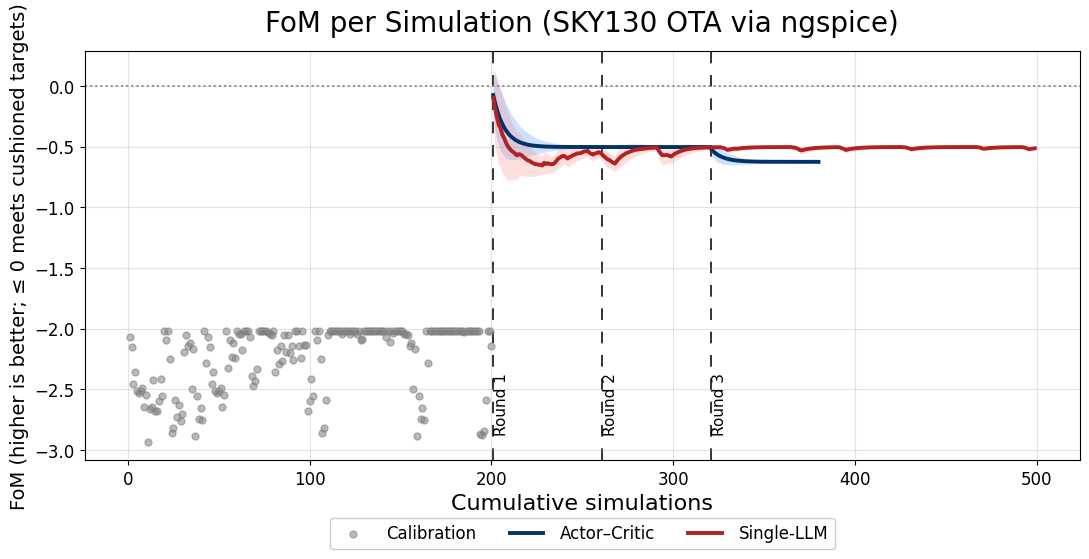

In [53]:
# Final plot — EMA mean with SE shading (AC vs Single-LLM)
import numpy as np
import matplotlib.pyplot as plt

def traces_from_history(hist):
    return [np.array([rec["fom"] for rec in h["all"]]) for h in hist]

def ewm_mean_se(y, alpha=0.15):
    y = np.asarray(y, dtype=float)
    n = len(y)
    mu, var, se = np.zeros(n), np.zeros(n), np.zeros(n)
    mu_prev = var_prev = 0.0
    sum_w = sum_w2 = 0.0
    one_ma = 1.0 - alpha
    for t in range(n):
        x = y[t]
        sum_w  = one_ma * sum_w  + alpha
        sum_w2 = (one_ma**2) * sum_w2 + alpha**2
        mu_t   = one_ma * mu_prev + alpha * x
        var_t  = one_ma * (var_prev + alpha * (x - mu_prev)**2)
        n_eff  = (sum_w**2) / max(sum_w2, 1.0)
        mu[t], var[t] = mu_t, var_t
        se[t]  = np.sqrt(max(var_t, 0.0)) / np.sqrt(max(n_eff, 1.0))
        mu_prev, var_prev = mu_t, var_t
    return mu, se

cal_color = "#808080"
ac_line   = "#003366"
sr_line   = "#B22222"
ac_fill   = "#3A8DFF"
sr_fill   = "#FF7F7F"

calib_foms = np.array([ledro_fom({"gain_dB":p["metrics"]["gain_dB"],
                                  "ugbw_MHz":p["metrics"]["ugbw_MHz"],
                                  "phase_margin_deg":clamp_pm_for_scoring(p["metrics"]["phase_margin_deg"]),
                                  "power_mW":p["metrics"]["power_mW"]}, b=BOUND) for p in CALIB_POOL])
x_cal, post_cal = np.arange(1, len(calib_foms)+1), len(calib_foms)
ac_trs, sr_trs = traces_from_history(history), traces_from_history(history_sr)

x_ac, x_sr = [], []
off = post_cal
for t in ac_trs:
    xa = off + np.arange(1, len(t)+1)
    x_ac.append(xa)
    off += len(t)
off = post_cal
for t in sr_trs:
    xs = off + np.arange(1, len(t)+1)
    x_sr.append(xs)
    off += len(t)

x_ac_all = np.concatenate(x_ac) if x_ac else np.array([])
y_ac_all = np.concatenate(ac_trs) if ac_trs else np.array([])
x_sr_all = np.concatenate(x_sr) if x_sr else np.array([])
y_sr_all = np.concatenate(sr_trs) if sr_trs else np.array([])

alpha = 0.15
mu_ac, se_ac = ewm_mean_se(y_ac_all, alpha) if len(y_ac_all) else ([], [])
mu_sr, se_sr = ewm_mean_se(y_sr_all, alpha) if len(y_sr_all) else ([], [])

round_x = []
cum = post_cal
for t in ac_trs:
    round_x.append(cum + 1)
    cum += len(t)

fig, ax = plt.subplots(figsize=(11,6))
ax.scatter(x_cal, calib_foms, s=25, alpha=0.55, color=cal_color, label="Calibration", zorder=1)
if len(x_ac_all):
    ax.plot(x_ac_all, mu_ac, color=ac_line, lw=2.8, label="Actor–Critic", zorder=4)
    ax.fill_between(x_ac_all, mu_ac - se_ac, mu_ac + se_ac, color=ac_fill, alpha=0.25, linewidth=0, zorder=2)
if len(x_sr_all):
    ax.plot(x_sr_all, mu_sr, color=sr_line, lw=2.8, label="Single-LLM", zorder=4)
    ax.fill_between(x_sr_all, mu_sr - se_sr, mu_sr + se_sr, color=sr_fill, alpha=0.25, linewidth=0, zorder=2)

vls = (0, (6,6))
for i, rx in enumerate(round_x, 1):
    ax.axvline(x=rx, color="black", linestyle=vls, lw=1.4, alpha=0.8, zorder=0)
    ax.text(rx + 0.5, 0.06, f"Round {i}", rotation=90, va="bottom", ha="left",
            transform=ax.get_xaxis_transform(), fontsize=11, color="black")

ax.axhline(0.0, ls=":", color="gray", lw=1.4, alpha=0.9)
ax.set_title("FoM per Simulation (SKY130 OTA via ngspice)", fontsize=20, pad=14)
ax.set_xlabel("Cumulative simulations", fontsize=16)
ax.set_ylabel("FoM (higher is better; ≤ 0 meets cushioned targets)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True, alpha=0.35)

handles, labels = ax.get_legend_handles_labels()
keep = {"Calibration", "Actor–Critic", "Single-LLM"}
h_final, l_final, seen = [], [], set()
for h, l in zip(handles, labels):
    if l in keep and l not in seen:
        seen.add(l); h_final.append(h); l_final.append(l)
ax.legend(h_final, l_final, fontsize=12, frameon=True, loc="upper center",
          fancybox=True, framealpha=0.95, ncol=3, handletextpad=1.0, bbox_to_anchor=(0.5, -0.12))

fig.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()


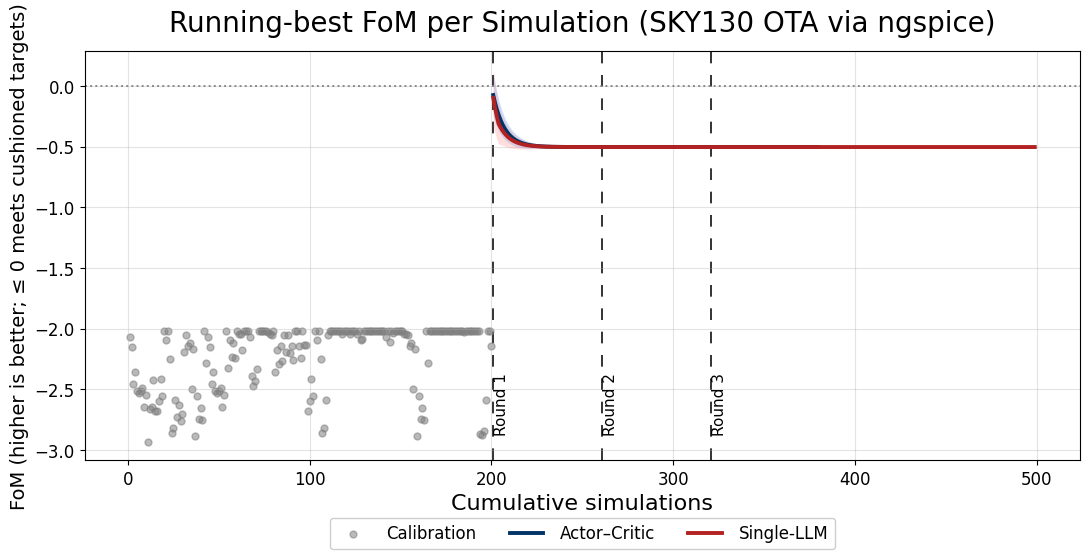

In [54]:
# Final plot — Running-best FoM with EMA smoothing (AC vs Single-LLM)
import numpy as np
import matplotlib.pyplot as plt

def traces_from_history(hist):
    return [np.array([rec["fom"] for rec in h["all"]]) for h in hist]

def ewm_mean_se(y, alpha=0.15):
    y = np.asarray(y, dtype=float)
    n = len(y)
    mu, var, se = np.zeros(n), np.zeros(n), np.zeros(n)
    mu_prev = var_prev = 0.0
    sum_w = sum_w2 = 0.0
    one_ma = 1.0 - alpha
    for t in range(n):
        x = y[t]
        sum_w  = one_ma * sum_w  + alpha
        sum_w2 = (one_ma**2) * sum_w2 + alpha**2
        mu_t   = one_ma * mu_prev + alpha * x
        var_t  = one_ma * (var_prev + alpha * (x - mu_prev)**2)
        n_eff  = (sum_w**2) / max(sum_w2, 1.0e-12)
        mu[t], var[t] = mu_t, var_t
        se[t]  = np.sqrt(max(var_t, 0.0)) / np.sqrt(max(n_eff, 1.0))
        mu_prev, var_prev = mu_t, var_t
    return mu, se

def running_best(y):
    y = np.asarray(y, dtype=float)
    if y.size == 0:
        return y
    return np.maximum.accumulate(y)

# Colors / styles
cal_color = "#808080"
ac_line   = "#003366"  # Actor–Critic (blue)
sr_line   = "#B22222"  # Single-LLM (red)
ac_fill   = "#3A8DFF"
sr_fill   = "#FF7F7F"

# Calibration FoMs
calib_foms = np.array([
    ledro_fom({
        "gain_dB": p["metrics"]["gain_dB"],
        "ugbw_MHz": p["metrics"]["ugbw_MHz"],
        "phase_margin_deg": clamp_pm_for_scoring(p["metrics"]["phase_margin_deg"]),
        "power_mW": p["metrics"]["power_mW"]
    }, b=BOUND) for p in CALIB_POOL
])
x_cal, post_cal = np.arange(1, len(calib_foms)+1), len(calib_foms)

# Per-simulation FoMs (all evaluations) pulled from history
ac_trs, sr_trs = traces_from_history(history), traces_from_history(history_sr)

# Build x-axes that continue after calibration
x_ac, x_sr = [], []
off = post_cal
for t in ac_trs:
    xa = off + np.arange(1, len(t)+1)
    x_ac.append(xa)
    off += len(t)
off = post_cal
for t in sr_trs:
    xs = off + np.arange(1, len(t)+1)
    x_sr.append(xs)
    off += len(t)

# Flatten
x_ac_all = np.concatenate(x_ac) if x_ac else np.array([])
y_ac_all = np.concatenate(ac_trs) if ac_trs else np.array([])
x_sr_all = np.concatenate(x_sr) if x_sr else np.array([])
y_sr_all = np.concatenate(sr_trs) if sr_trs else np.array([])

# Use running-best before smoothing
alpha = 0.15
y_ac_all_best = running_best(y_ac_all)
y_sr_all_best = running_best(y_sr_all)

mu_ac, se_ac = ewm_mean_se(y_ac_all_best, alpha) if len(y_ac_all_best) else ([], [])
mu_sr, se_sr = ewm_mean_se(y_sr_all_best, alpha) if len(y_sr_all_best) else ([], [])

# Round markers based on AC round boundaries
round_x = []
cum = post_cal
for t in ac_trs:
    round_x.append(cum + 1)
    cum += len(t)

# Plot
fig, ax = plt.subplots(figsize=(11,6))
ax.scatter(x_cal, calib_foms, s=25, alpha=0.55, color=cal_color, label="Calibration", zorder=1)

if len(x_ac_all):
    ax.plot(x_ac_all, mu_ac, color=ac_line, lw=2.8, label="Actor–Critic", zorder=4)
    ax.fill_between(x_ac_all, mu_ac - se_ac, mu_ac + se_ac, color=ac_fill, alpha=0.25, linewidth=0, zorder=2)
if len(x_sr_all):
    ax.plot(x_sr_all, mu_sr, color=sr_line, lw=2.8, label="Single-LLM", zorder=4)
    ax.fill_between(x_sr_all, mu_sr - se_sr, mu_sr + se_sr, color=sr_fill, alpha=0.25, linewidth=0, zorder=2)

vls = (0, (6,6))
for i, rx in enumerate(round_x, 1):
    ax.axvline(x=rx, color="black", linestyle=vls, lw=1.4, alpha=0.8, zorder=0)
    ax.text(rx + 0.5, 0.06, f"Round {i}", rotation=90, va="bottom", ha="left",
            transform=ax.get_xaxis_transform(), fontsize=11, color="black")

ax.axhline(0.0, ls=":", color="gray", lw=1.4, alpha=0.9)
ax.set_title("Running-best FoM per Simulation (SKY130 OTA via ngspice)", fontsize=20, pad=14)
ax.set_xlabel("Cumulative simulations", fontsize=16)
ax.set_ylabel("FoM (higher is better; ≤ 0 meets cushioned targets)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True, alpha=0.35)

handles, labels = ax.get_legend_handles_labels()
keep = {"Calibration", "Actor–Critic", "Single-LLM"}
h_final, l_final, seen = [], [], set()
for h, l in zip(handles, labels):
    if l in keep and l not in seen:
        seen.add(l); h_final.append(h); l_final.append(l)
ax.legend(h_final, l_final, fontsize=12, frameon=True, loc="upper center",
          fancybox=True, framealpha=0.95, ncol=3, handletextpad=1.0, bbox_to_anchor=(0.5, -0.12))

fig.tight_layout(rect=[0, 0.04, 1, 1])
plt.show()
